In [14]:
# Import all the libraries needed
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import time
import os
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


In [15]:
# Define the transformation/augmentation for the data
array_transforms = {
    'train':
    transforms.Compose([
#         transforms.RandomRotation(degrees=180),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ]),
    'val':
    transforms.Compose([
#         transforms.RandomRotation(degrees=180),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ]),
    'test':
    transforms.Compose([
#         transforms.RandomRotation(degrees=180),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ]),
}




# Tell the dataloader where to search and where to put the arrays
traindir = 'Data/traindir'
train_channels = [f'{traindir}/r_data', f'{traindir}/g_data']

valdir = 'Data/valdir'
val_channels = [f'{valdir}/r_data', f'{valdir}/g_data']

testdir = 'Data/testdir'
test_channels = [f'{testdir}/r_data', f'{testdir}/g_data']

train_inputs = []
train_labels = []

val_inputs = []
val_labels = []

test_inputs = []
test_labels = []




# Load the saved .npy arrays from the preprocessing.py file into the above arrays,
# split up the red and green channel again so that the axes match in size
def load_npy_arrays(phase):
    
    if phase == "train":
        phase_channels = train_channels
        phase_inputs = train_inputs
        phasedir = traindir
        phase_labels = train_labels
    
    elif phase == "val":
        phase_channels = val_channels
        phase_inputs = val_inputs
        phasedir = valdir
        phase_labels = val_labels
    
    elif phase == "test":
        phase_channels = test_channels
        phase_inputs = test_inputs
        phasedir = testdir
        phase_labels = test_labels
    
    else:
        print('Valueerror: please pass one of the three accepted strings("train", "val", "test")')

    for channel in phase_channels:
        path_to_channel = channel
        for file in os.listdir(channel):
            filename = file
            if filename.endswith('.npy'):
                loaded_array = np.load(f'{path_to_channel}/{filename}')
                phase_inputs.append(loaded_array)
                continue
            else:
                continue
                
    labelfolder = f'{phasedir}/labels'
    for file in os.listdir(labelfolder):
        filename = file
        if filename.endswith('.npy'):
            loaded_array = np.load(f'{labelfolder}/{filename}')
            phase_labels.append(loaded_array)
            continue
        else:
            continue
    print(np.shape(phase_labels))

load_npy_arrays("train")
load_npy_arrays("val")
load_npy_arrays("test")

print('Sum of all pixels in a label: ' ,np.sum(train_labels[0]))

train_inputs = np.asarray(train_inputs)
train_inputs = np.split(train_inputs, 2, axis=0)
train_inputs = np.asarray(train_inputs).transpose(1,0,2,3)
print(np.shape(train_inputs))

val_inputs = np.asarray(val_inputs)
val_inputs = np.split(val_inputs, 2, axis=0)
val_inputs = np.asarray(val_inputs).transpose(1,0,2,3)
print(np.shape(val_inputs))

test_inputs = np.asarray(test_inputs)
test_inputs = np.split(test_inputs, 2, axis=0)
test_inputs = np.asarray(test_inputs).transpose(1,0,2,3)
print(np.shape(test_inputs))


# Define our own dataset creator because we want to load numpy arrays,
# but still be able to apply transformations as if it were images
class CreateDataset(Dataset):
    def __init__(self, inputs, labels, transform=None):
        self.inputs = torch.FloatTensor(inputs)
        self.labels = torch.FloatTensor(labels)
        self.transform = transform

    def __getitem__(self, index):
        x = self.inputs[index]
        y = self.labels[index]

        if self.transform:
            x = Image.fromarray(self.inputs[index].numpy().astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.inputs)

    
# Get the data, transform it
data = {
   'train':
   CreateDataset(train_inputs, train_labels, transform = array_transforms['train']),
   'val':
   CreateDataset(val_inputs, val_labels, transform = array_transforms['val']),
    'test':
   CreateDataset(test_inputs, test_labels, transform = array_transforms['test']),
}


batch_size = 1

# Load Data in batches, shuffled
dataloaders = {
   'train': DataLoader(data['train'], batch_size=batch_size, shuffle=False),
   'val': DataLoader(data['val'], batch_size=batch_size, shuffle=False),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=False),
}

(1546, 100, 100)
(284, 100, 100)
(330, 100, 100)
Sum of all pixels in a label:  10.17876019763133
(1546, 2, 100, 100)
(284, 2, 100, 100)
(330, 2, 100, 100)


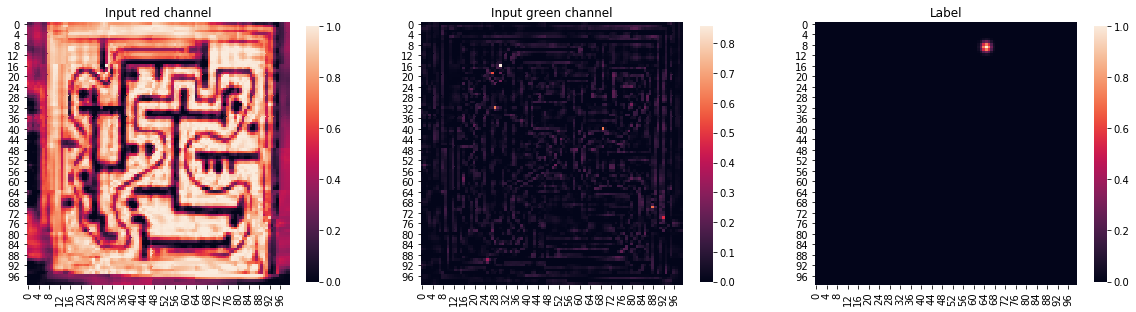

In [16]:
# Visualize the input of the CNN

inputs, labels = next(iter(dataloaders['train'])) # Pick a batch
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(3, 3, 1)
ax1.set_title('Input red channel')
ax2 = fig.add_subplot(3, 3, 2)
ax2.set_title('Input green channel')
ax3 = fig.add_subplot(3, 3, 3)
ax3.set_title('Label')

sns.heatmap(inputs[0][0], ax=ax1, square=True, cbar_kws={'shrink': .8})
sns.heatmap(inputs[0][1], ax=ax2, square=True, cbar_kws={'shrink': .8})
sns.heatmap(labels[0], ax=ax3, square=True, cbar_kws={'shrink': .8})
plt.show()

In [17]:
# Load in pretrained VGG16 net, extract the FCN part, delete pooling layers,
# modify first layer to recieve 2 channels, the last one to output depth 1

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

vgg16 = models.vgg16(pretrained=True)
vgg16_mod = vgg16.features
vgg16_mod[0] = nn.Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
vgg16_mod[4] = nn.Identity()
vgg16_mod[9] = nn.Identity()
vgg16_mod[16] = nn.Identity()
vgg16_mod[23] = nn.Identity()
vgg16_mod[28] = nn.Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
vgg16_mod[30] = nn.Identity()
print(vgg16_mod)

Sequential(
  (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): Identity()
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): Identity()
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Identity()
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU(inplace)
  (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (20): ReLU(inplace)
  (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), paddi

In [18]:
# Check if GPU is available and move the model over to GPU
if torch.cuda.is_available():
    device = torch.device("cuda: 0")
    gpu_name = torch.cuda.get_device_name()
    print(f"Running on your {gpu_name} (GPU)")
else:
    device = torch.device("cpu")
    print("Running on your CPU")

net = vgg16_mod.to(device)

Running on your GeForce 920M (GPU)


In [19]:
# Define the training loop with loss-function and optimizer

loss_fn = nn.L1Loss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=0.001)

epochs = 1
epochs_no_improve_limit = 5

train_losses = []
val_losses = []


def train():
    epochs_no_improve = 0
    min_val_loss = np.Inf
    since = time.time()
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)
        val_loss = 0
        
        for train_inputs, train_labels in dataloaders['train']:
            optimizer.zero_grad()
            output = net(train_inputs.to(device)).reshape(batch_size, 100, 100)
            print(output.shape)
            print(np.sum(output[0].cpu().detach().numpy()))
            loss = loss_fn(output.cpu(), train_labels.cpu())
            train_losses.append(loss)
            print('Training Loss: {:.4f}'.format(loss))
            loss.backward()
            optimizer.step()
            
        for val_inputs, val_labels in dataloaders['val']:
            output = net(val_inputs.to(device)).reshape(batch_size, 100, 100)
            loss = loss_fn(output.cpu(), val_labels.cpu())
            val_loss += loss
            
        val_loss = val_loss / len(dataloaders['val'])
        val_losses.append(val_loss)
        print('-' * 10)
        print('Validation Loss: {:.4f}'.format(val_loss))
        
        if val_loss < min_val_loss:
            torch.save(net, 'Nets/pt-labi_CNN.pt')
            epochs_no_improve = 0
            min_val_loss = val_loss
        else:
            epochs_no_improve += 1
            if epochs_no_improve == epochs_no_improve_limit:
                print('Early stopping initiated')
                model = torch.load('Nets/pt-labi_CNN.pt')
                print('Best model so far has been loaded')
    print('Least validation Loss: {:4f}'.format(min_val_loss))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Finished training')
train()

Epoch 1/1
----------
torch.Size([1, 100, 100])
526.8411
Training Loss: 532.3040
torch.Size([1, 100, 100])
0.0
Training Loss: 10.1788
torch.Size([1, 100, 100])
0.0
Training Loss: 10.1788
torch.Size([1, 100, 100])
0.0
Training Loss: 10.1788
torch.Size([1, 100, 100])
0.0
Training Loss: 10.1788
torch.Size([1, 100, 100])
0.0
Training Loss: 10.1788
torch.Size([1, 100, 100])
0.0
Training Loss: 10.1788
torch.Size([1, 100, 100])
0.0
Training Loss: 10.1788
torch.Size([1, 100, 100])
0.0
Training Loss: 10.1788
torch.Size([1, 100, 100])
0.0
Training Loss: 10.1788
torch.Size([1, 100, 100])
0.0
Training Loss: 10.1788
torch.Size([1, 100, 100])
0.0
Training Loss: 10.1788
torch.Size([1, 100, 100])
0.0
Training Loss: 10.1788
torch.Size([1, 100, 100])
0.0
Training Loss: 10.1788
torch.Size([1, 100, 100])
0.0
Training Loss: 10.1788
torch.Size([1, 100, 100])
0.0
Training Loss: 10.1788
torch.Size([1, 100, 100])
0.0
Training Loss: 10.1788
torch.Size([1, 100, 100])
0.0
Training Loss: 10.1788
torch.Size([1, 100,

KeyboardInterrupt: 

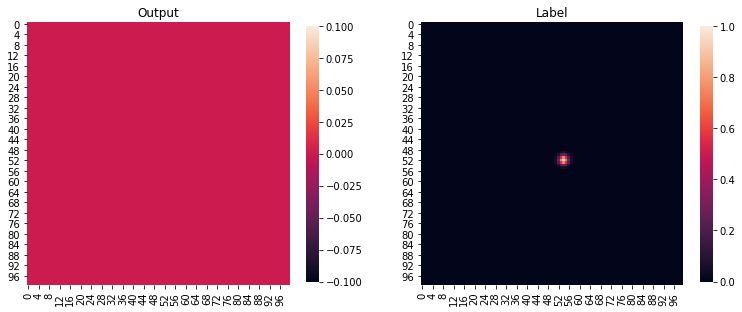

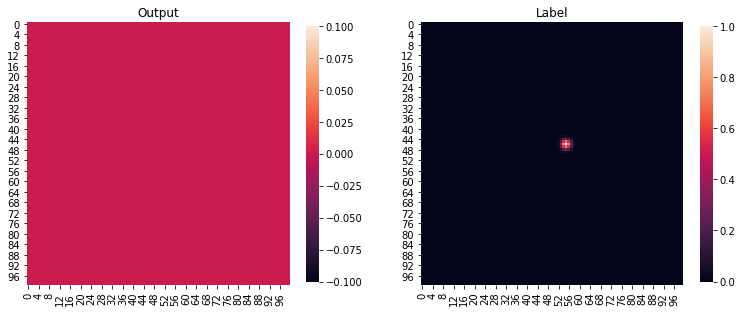

KeyboardInterrupt: 

In [20]:
# Define the testing loop and output some heatmaps
# to estimate the performance of the CNN

def test():
    for test_inputs, test_labels in dataloaders['test']:
        output = net(test_inputs.to(device)).reshape(1, 100, 100)
        loss = loss_fn(output.cpu(), test_labels.cpu())
        output = output.reshape(100, 100).cpu().detach().numpy()
        test_labels = test_labels.reshape(100, 100)

        fig = plt.figure(figsize = (20,20))
        ax1 = fig.add_subplot(3, 3, 1)
        ax1.set_title('Output')
        ax2 = fig.add_subplot(3, 3, 2)
        ax2.set_title('Label')

        sns.heatmap(output, ax=ax1, square=True, cbar_kws={'shrink': .8})
        sns.heatmap(test_labels, ax=ax2, square=True, cbar_kws={'shrink': .8})
        plt.show()
test()